In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

# mendefinisikan path
train_dir = '/kaggle/input/face-shape-dataset/FaceShape Dataset/training_set'
test_dir = '/kaggle/input/face-shape-dataset/FaceShape Dataset/testing_set'


In [3]:
# mendefinisikan ukuran gambar
img_width = 150
img_height = 150

# mendefinisikan batch size
batch_size = 128

# mendefinisikan jumlah epoch
epochs = 100

# mendefinisikan jumlah kelas
num_classes = 5

# mendefinisikan model
model = Sequential()
model.add(Flatten(input_shape=(img_width, img_height, 3)))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow loading truncated images

class SafeImageDataGenerator(ImageDataGenerator):
    def load_img(self, path):
        try:
            img = load_img(path, target_size=(img_width, img_height))
            x = img_to_array(img)
            return x
        except Exception as e:
            print(f"Error loading image {path}: {str(e)}")
            return None
            
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, *args, **kwargs)
        
        def safe_next():
            while True:
                try:
                    return next(generator)
                except Exception as e:
                    print(f"Skipping corrupted batch: {str(e)}")
                    continue
                    
        generator.next = safe_next
        return generator

In [25]:
# Data preparation
train_datagen = SafeImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = SafeImageDataGenerator(rescale=1.0/255)

# Modified data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [26]:
# membuat callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.00001, verbose=1)


history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100


I0000 00:00:1730856331.555702     112 service.cc:145] XLA service 0x787d7400b370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730856331.555763     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/32 ━━━━━━━━━━━━━━━━━━━━ 6:54 13s/step - accuracy: 0.2578 - loss: 1.6098

I0000 00:00:1730856333.260471     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.2005 - loss: 2.7563 - val_accuracy: 0.2330 - val_loss: 1.6036 - learning_rate: 1.0000e-04
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2142 - loss: 1.6490 - val_accuracy: 0.2330 - val_loss: 1.6086 - learning_rate: 1.0000e-04
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2316 - loss: 1.6571 - val_accuracy: 0.2140 - val_loss: 1.6494 - learning_rate: 1.0000e-04
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2154 - loss: 1.6524 - val_accuracy: 0.2090 - val_loss: 1.6827 - learning_rate: 1.0000e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2090 - loss: 1.6791 - val_accuracy: 0.2290 - val_loss: 1.6353 - learning_rate: 1.0000e-04
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2226 - loss: 1.6373
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2227 - loss: 1.6375 - v

In [28]:
# evaluasi model
model.save('model.h5')
model = tf.keras.models.load_model('model.h5')
loss, acc = model.evaluate(test_generator)
print('Test Accuracy:', acc)
print('Test Loss:', loss)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 812ms/step - accuracy: 0.1377 - loss: 1.6618
Test Accuracy: 0.23000000417232513
Test Loss: 1.6039040088653564


In [30]:
# prediksi model
test_generator.reset()
pred = model.predict(test_generator)


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 823ms/step


In [31]:
# mendapatkan label
labels = test_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

In [32]:
# mendapatkan hasil prediksi
pred = np.argmax(pred, axis=1)
pred = [labels[k] for k in pred]

In [33]:
# mendapatkan label sebenarnya
actual = test_generator.classes
actual = [labels[k] for k in actual]

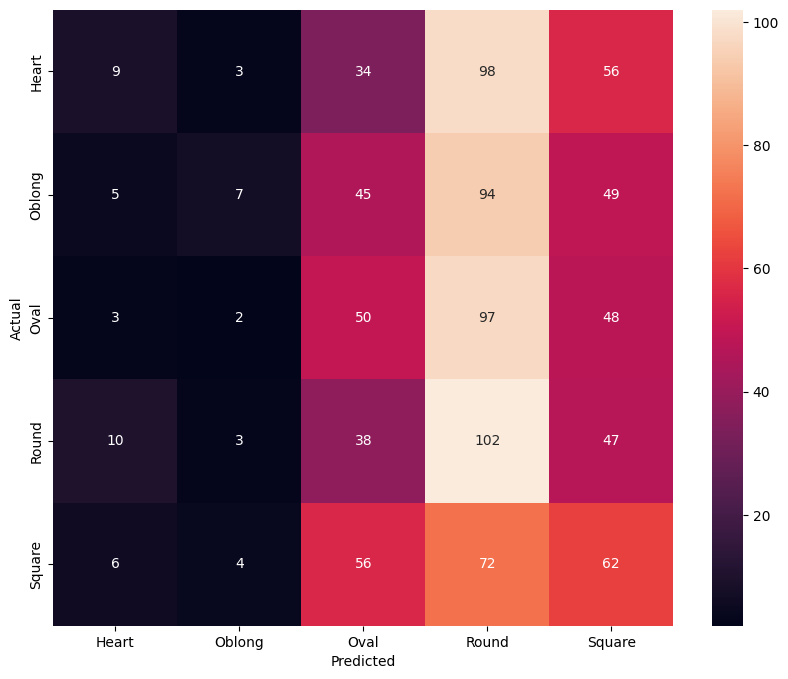

In [34]:
# plot hasil prediksi actual vs pred
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(actual, pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()